In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)
np.random.seed(42)
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


## 1. Load & Explore Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dat=pd.read_csv("/content/drive/MyDrive/Heart_Disease_Prediction.csv")

print('Shape:', dat.shape)
dat.head()

Mounted at /content/drive
Shape: (270, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

Target distribution:
Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64


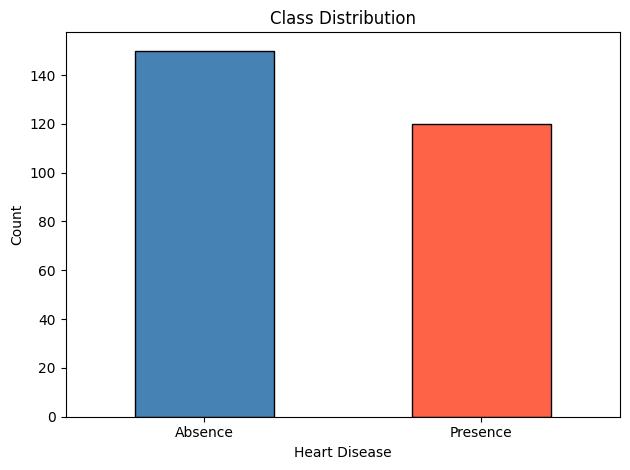

In [3]:
print(dat.isnull().sum())
print()
print("Target distribution:")
print(dat['Heart Disease'].value_counts())

dat['Heart Disease'].value_counts().plot(kind='bar', color=['steelblue','tomato'],
                                          title='Class Distribution', edgecolor='black')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 2. Preprocessing

In [5]:
X = dat.drop(columns='Heart Disease', axis=1)
Y = dat['Heart Disease'].map({'Absence': 0, 'Presence': 1})

print('Features shape:', X.shape)
print('Positive (Presence) rate: {:.1f}%'.format(Y.mean() * 100))

Features shape: (270, 13)
Positive (Presence) rate: 44.4%


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print('Train:', X_train.shape, '| Test:', X_test.shape)

Train: (216, 13) | Test: (54, 13)


In [8]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

classes = np.unique(Y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weight_dict = dict(zip(classes, weights))
print('Class weights:', class_weight_dict)

Class weights: {np.int64(0): np.float64(0.9), np.int64(1): np.float64(1.125)}


3. Model Building

In [9]:
def build_model(input_dim: int) -> keras.Model:
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(128, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(64, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(1, activation='sigmoid')
    ], name='HeartDisease_Improved')
    return model

model = build_model(X_train_std.shape[1])
model.summary()

Model: "HeartDisease_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 45,697 (178.50 KB)

 Non-trainable params: 896 (3.50 KB)

## 4. Compile & Train (≤ 15 Epochs)

In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,           # waits 4 epochs for improvement before stopping
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

In [13]:
history = model.fit(
    X_train_std, Y_train,
    validation_split=0.15,
    epochs=15,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

print(f"\nTraining stopped at epoch {len(history.history['loss'])}")

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6511 - loss: 0.7061 - val_accuracy: 0.7879 - val_loss: 0.6698 - learning_rate: 0.0050
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8269 - loss: 0.3903 - val_accuracy: 0.7576 - val_loss: 0.6873 - learning_rate: 0.0050
Epoch 3/15
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9375 - loss: 0.2555
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8529 - loss: 0.3633 - val_accuracy: 0.7879 - val_loss: 0.8154 - learning_rate: 0.0050
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8482 - loss: 0.3106 - val_accuracy: 0.7576 - val_loss: 0.7788 - learning_rate: 0.0025
Epoch 5/15
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8750 - loss: 0.2602
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8900 - loss: 0.2766 - val_accuracy:

## 5. Training Curves

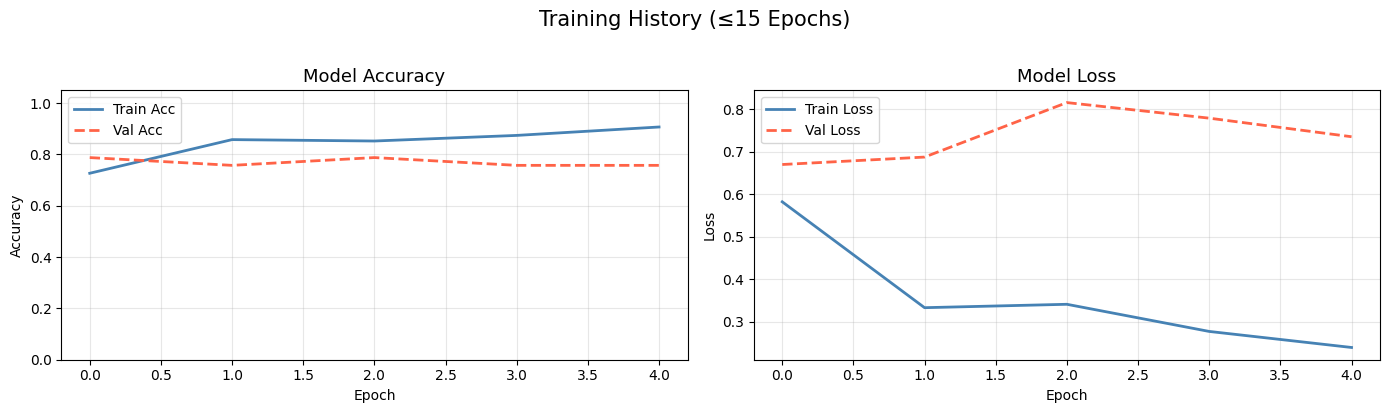

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history.history['accuracy'],     label='Train Acc',  color='steelblue', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Acc',    color='tomato',    linewidth=2, linestyle='--')
axes[0].set_title('Model Accuracy', fontsize=13)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1.05)

axes[1].plot(history.history['loss'],     label='Train Loss', color='steelblue', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss',   color='tomato',    linewidth=2, linestyle='--')
axes[1].set_title('Model Loss', fontsize=13)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History (≤15 Epochs)', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Evaluation on Test Set

In [15]:
Y_pred_prob = model.predict(X_test_std).flatten()
Y_pred      = (Y_pred_prob >= 0.5).astype(int)

test_acc = accuracy_score(Y_test, Y_pred)
roc_auc  = roc_auc_score(Y_test, Y_pred_prob)

print('=' * 45)
print(f'  Test Accuracy : {test_acc:.4f}  ({test_acc*100:.2f}%)')
print(f'  ROC-AUC Score : {roc_auc:.4f}')
print('=' * 45)
print()
print('Classification Report:')
print(classification_report(Y_test, Y_pred, target_names=['Absence','Presence']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
  Test Accuracy : 0.7963  (79.63%)
  ROC-AUC Score : 0.8653

Classification Report:
              precision    recall  f1-score   support

     Absence       0.83      0.80      0.81        30
    Presence       0.76      0.79      0.78        24

    accuracy                           0.80        54
   macro avg       0.79      0.80      0.79        54
weighted avg       0.80      0.80      0.80        54



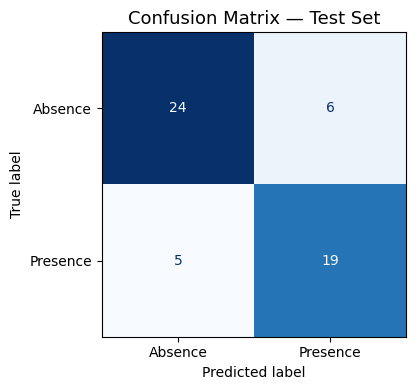

In [16]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Absence', 'Presence'])

fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, colorbar=False, cmap='Blues')
ax.set_title('Confusion Matrix — Test Set', fontsize=13)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

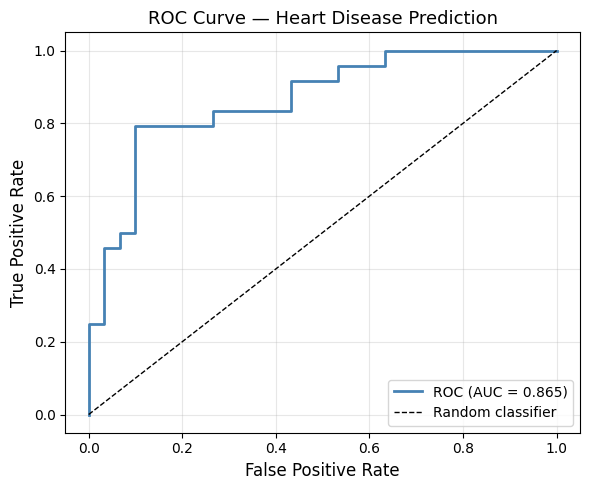

In [17]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='steelblue', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve — Heart Disease Prediction', fontsize=13)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Predict on New Input

In [18]:
input_data = np.array([[63, 1, 3, 145, 233, 1, 2, 150, 0, 2.3, 3, 0, 6]])
input_std  = scaler.transform(input_data)
prob       = model.predict(input_std)[0][0]
label      = 'Presence' if prob >= 0.5 else 'Absence'

print(f'Prediction  : {label}')
print(f'Probability : {prob:.4f}  ({prob*100:.1f}% chance of Heart Disease)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction  : Presence
Probability : 0.9650  (96.5% chance of Heart Disease)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
